<a href="https://colab.research.google.com/github/brianellis1997/Sarcasm_Detection/blob/Lindsey/DS_440_Traditional_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarcasm Detection using NLP Techniques
### Team 2: Brian Ellis, Lindsey Rich, Elena Kern

## Load Libraries and Dataset

In [1]:
import pandas as pd
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#test comment

In [2]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [3]:
!git clone https://github.com/brianellis1997/Sarcasm_Detection.git

Cloning into 'Sarcasm_Detection'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 158 (delta 87), reused 112 (delta 62), pack-reused 3
Receiving objects: 100% (158/158), 3.31 MiB | 12.42 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_bal = pd.read_csv('/content/drive/MyDrive/Sarcasm_Data/Train_Balanced.csv')   # Make sure path is correct in your google drive
train_bal.head()

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,522142,0,"I personally wasn't a huge Garrosh fan, I've a...",cromemako83,AskReddit,2,2,0,2015-07-01,2015-07-11 01:55:53,Fuck Vol'jin. Garrosh Hellscream did nothing w...
1,907864,1,you forgot the,_SharkWeek_,AskReddit,1,1,0,2013-03-01,2013-03-14 03:03:46,That's a lie fed to you by the LIEberal media....
2,604170,1,"Nah man, she's clearly an ad carry",jdswift13,leagueoflegends,1,1,0,2015-10-01,2015-10-21 23:22:17,she isnt already?
3,110635,1,This sub in a nutshell.,trickz-M-,GlobalOffensive,1,-1,-1,2016-12-01,2016-12-05 03:50:18,Cloud 9 Qualify! (ONLY C9 FANS ALLOWED(
4,997758,0,Yes... I do.,guriboysf,videos,4,4,0,2010-01-01,2010-01-17 21:32:40,"""so, i hear you have a fat cock."""


In [6]:
test = pd.read_csv('/content/drive/MyDrive/Sarcasm_Data/Test_Balanced.csv')

In [7]:
train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808618 entries, 0 to 808617
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      808618 non-null  int64 
 1   label           808618 non-null  int64 
 2   comment         808618 non-null  object
 3   author          808618 non-null  object
 4   subreddit       808618 non-null  object
 5   score           808618 non-null  int64 
 6   ups             808618 non-null  int64 
 7   downs           808618 non-null  int64 
 8   date            808618 non-null  object
 9   created_utc     808618 non-null  object
 10  parent_comment  808618 non-null  object
dtypes: int64(5), object(6)
memory usage: 67.9+ MB


In [8]:
train_bal['label'].value_counts()

1    404369
0    404249
Name: label, dtype: int64

We can see our dataset is balanced.

In [9]:
train_bal['label'].value_counts(normalize=True)

1    0.500074
0    0.499926
Name: label, dtype: float64

#New dataframe with more feature engineered covariates

In [10]:
train_bal['exclamation_count'] = train_bal['comment'].apply(lambda x: x.count('!'))

In [11]:
train_bal['questionmark_count'] = train_bal['comment'].apply(lambda x: x.count('?'))

In [12]:
train_bal['period_count'] = train_bal['comment'].apply(lambda x: x.count('.'))

In [13]:
train_bal['space_count'] = train_bal['comment'].apply(lambda x: x.count('_'))

In [14]:
train_bal['slash_count'] = train_bal['comment'].apply(lambda x: x.count('/'))

In [15]:
train_bal['elips_count'] = train_bal['comment'].apply(lambda x: x.count(':'))

In [16]:
import pandas as pd

train_bal['capital_letters_count'] = train_bal['comment'].apply(lambda x: sum(1 for char in x if char.isupper()))


In [17]:
train_bal['word_count'] = train_bal['comment'].apply(lambda x: len(x.split()))

In [18]:
import pandas as pd
import string

def count_punctuation(comment):
    return sum(1 for char in comment if char in string.punctuation)


train_bal['total_punctuation'] = train_bal['comment'].apply(count_punctuation)


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


<ipython-input-20-8cf9a1affa3e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=column, data=train_bal, ax=axs[i], palette="Set2")
<ipython-input-20-8cf9a1affa3e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=column, data=train_bal, ax=axs[i], palette="Set2")
<ipython-input-20-8cf9a1affa3e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=column, data=train_bal, ax=axs[i], palette="Set2")
<ipython-input-20-8cf9a1affa3e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated 

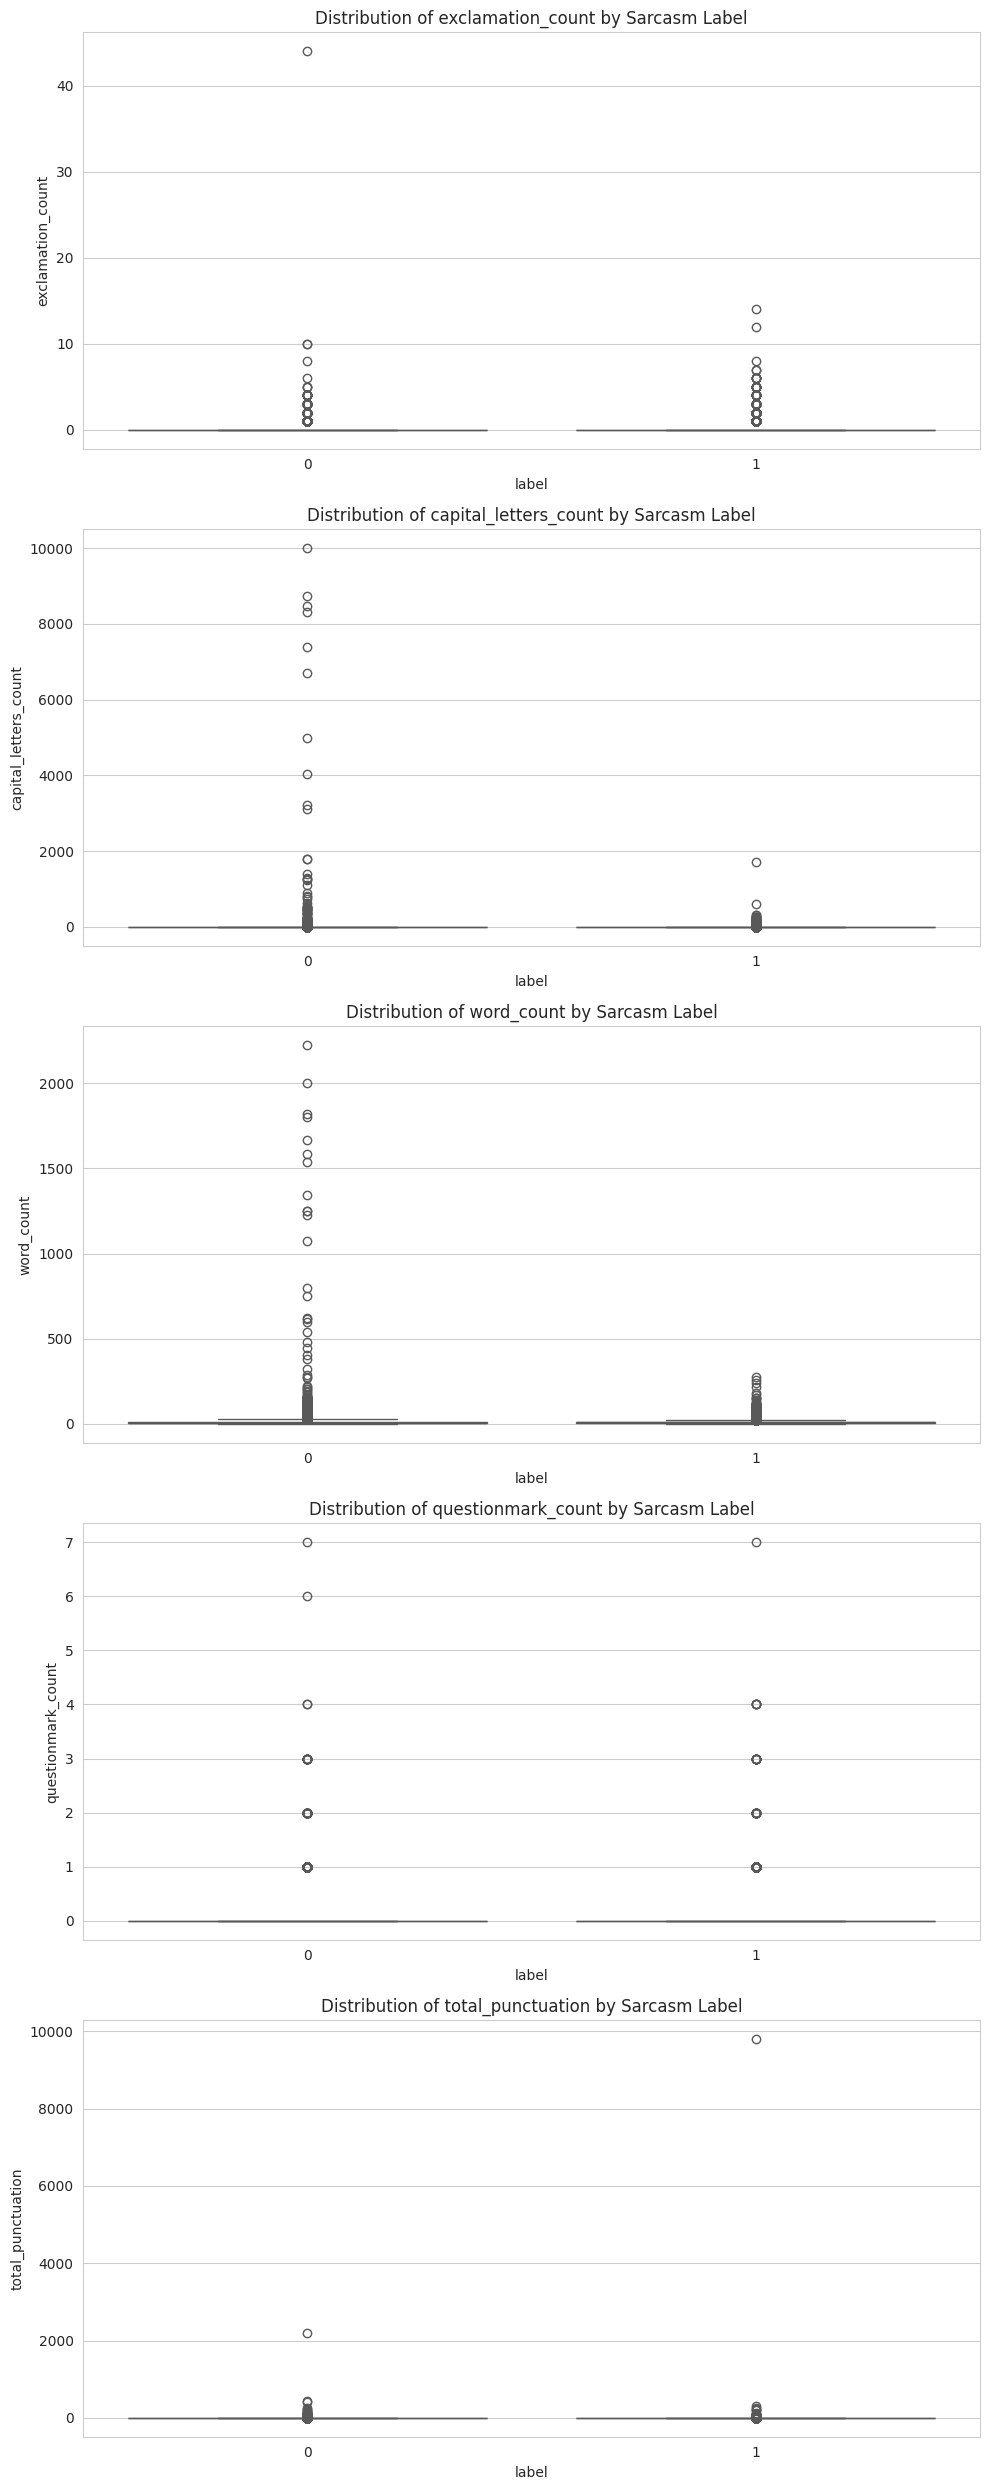

In [20]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# List of columns you want to visualize
columns = ['exclamation_count', 'capital_letters_count', 'word_count', 'questionmark_count', 'total_punctuation']

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 5*len(columns)))

for i, column in enumerate(columns):
    sns.boxplot(x='label', y=column, data=train_bal, ax=axs[i], palette="Set2")
    axs[i].set_title(f'Distribution of {column} by Sarcasm Label')

# Adjust layout
plt.tight_layout()
plt.show()


## EDA

In [21]:
# Separating sarcastic vs non sarcastic comments
sarcastic_com = train_bal[train_bal['label'] == 1]
non_sarcastic_com = train_bal[train_bal['label'] == 0]

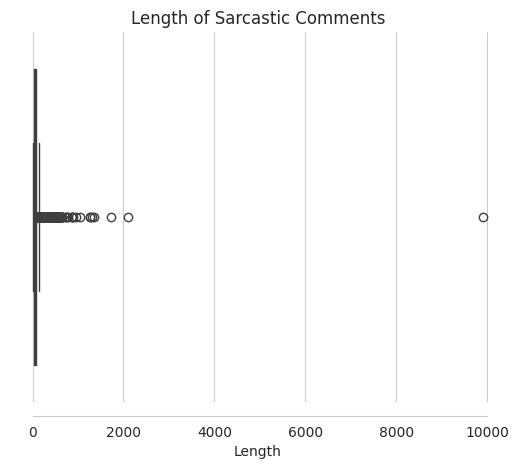

In [22]:
# distribution of the lenth of Sarcastic comments
sns.boxplot(x= sarcastic_com.loc[sarcastic_com['label'] == 1, 'comment'].str.len()).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

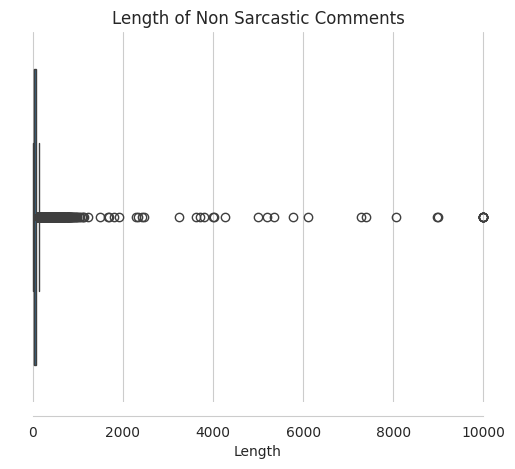

In [23]:
# distribution of the lenth of Sarcastic comments
sns.boxplot(x= non_sarcastic_com.loc[non_sarcastic_com['label'] == 0, 'comment'].str.len()).set(title = 'Length of Non Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

In [24]:
import numpy as np

sarcasm_score = np.array(sarcastic_com.loc[sarcastic_com['label'] == 1]['score'])
neutral_score = np.array(sarcastic_com.loc[sarcastic_com['label'] == 0]['score'])

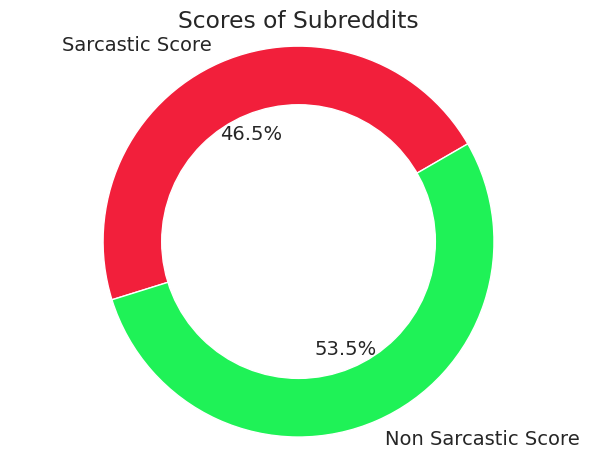

In [25]:

labels = ['Sarcastic Score', 'Non Sarcastic Score']
sizes = [3235069, 3725113]
colors = ['#F21F3B', '#1FF257']

plt.rcParams.update({'font.size': 14})
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=30)
ax1.set_title("Scores of Subreddits")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
plt.tight_layout()
plt.show()

In [26]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')

import string

import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

import spacy # for a lemmatization example

from sklearn.manifold import TSNE

import pandas as pd
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
# import nltk
# from nltk.corpus import stopwords

# # Download stopwords if not already downloaded
# nltk.download('stopwords')

# # Get the English stopwords
# stpwrds = set(stopwords.words('english'))

# # Assuming 'comment' is the column containing the sentences in your DataFrame
# comments = train_bal['comment']

# # Function to tokenize, lowercase, and remove stopwords from each comment
# def clean_comments(comments):
#     clean_comments_list = []
#     for comment in comments:
#         # Tokenize and lowercase
#         tokens = comment.lower().split()

#         # Remove stopwords
#         cleaned_tokens = [token for token in tokens if token not in stpwrds]

#         clean_comments_list.append(cleaned_tokens)

#     return clean_comments_list

In [28]:
# sarcastic_comments = sarcastic_com['comment']
# non_sarcastic_comments = non_sarcastic_com['comment']

# # Apply the function to sarcastic and non-sarcastic comments
# sarcastic_clean = clean_comments(sarcastic_comments)
# non_sarcastic_clean = clean_comments(non_sarcastic_comments)

# # Example output for the first 10 sarcastic comments
# print(sarcastic_clean[:10])

In [29]:
# from gensim.models.phrases import Phraser, Phrases

# # Add common two-word phrases aka Bi-grams
# sarc_bigrams = Phraser(Phrases(sarcastic_clean, min_count=32, threshold=64))
# non_sarc_bigrams = Phraser(Phrases(non_sarcastic_clean, min_count=32, threshold=64))

# # Apply the bigram models to the tokenized lists
# clean_sarc = [sarc_bigrams[sentence] for sentence in sarcastic_clean]
# clean_non_sarc = [non_sarc_bigrams[sentence] for sentence in non_sarcastic_clean]

# # Example output for the first 10 sarcastic comments after adding bigrams
# print(clean_sarc[:10])

In [30]:
# # WordCloud for sarcastic comments
# wordcloud_sarc = WordCloud(width=800, height=400, background_color='white').generate(' '.join([' '.join(sentence) for sentence in clean_sarc]))

# # Display the generated word cloud using matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud_sarc, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud for Sarcastic Comments')
# plt.show()


In [31]:
# # WordCloud for sarcastic comments
# wordcloud_sarc = WordCloud(width=800, height=400, background_color='white').generate(' '.join([' '.join(sentence) for sentence in clean_non_sarc]))

# # Display the generated word cloud using matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud_sarc, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud for Non-Sarcastic Comments')
# plt.show()

# Visualizing Sarcastic Comments by Subreddit

In [32]:
# subreddit_count = sarcastic_com['subreddit'].value_counts()

In [33]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# top = subreddit_count.head(20)
# plt.figure(figsize=(10, 6))
# sns.barplot(x=top.values, y=top.index)
# plt.xlabel('Number of Sarcastic Comments')
# plt.ylabel('Subreddit')
# plt.title('Frequency of Sarcastic Comments by Subreddit')
# plt.show()


## Train Logistic Regression model (baseline)

In [34]:
from sklearn.model_selection import train_test_split
comments = train_bal['comment']
# Create a new column 'merged_comment' by concatenating 'comment' and 'parent_comment'
train_bal['merged_comment'] = train_bal['comment'] + ' ' + train_bal['parent_comment']

labels = train_bal['label']

X_train, X_test, y_train, y_test = train_test_split(train_bal['merged_comment'], labels, test_size=0.3, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(566032,)
(242586,)


In [35]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline

# # build bigrams
# # and minimal word frequency
# tf_idf = TfidfVectorizer(ngram_range=(1, 2), min_df=2, lowercase=False)
# # multinomial logistic regression a.k.a softmax classifier
# logit = LogisticRegression(C=1, n_jobs=-1, solver='lbfgs',
#                            random_state=42, verbose=1)
# # sklearn's pipeline
# tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf),
#                                  ('logit', logit)])

In [36]:
# %%time
# tfidf_logit_pipeline.fit(X_train, y_train)

In [37]:
# %%time
# valid_pred = tfidf_logit_pipeline.predict(X_test)

In [38]:
# from sklearn.metrics import accuracy_score

# accuracy_score(y_test, valid_pred)

## Stacking with parent comment

In [39]:
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
tf_idf_comment = TfidfVectorizer(ngram_range=(1, 2), min_df=2, lowercase=False)
tf_idf_parent_comment = TfidfVectorizer(ngram_range=(1, 2), min_df=2, lowercase=False)

comment_vectors = tf_idf_comment.fit_transform(train_bal['comment'])
parent_comment_vectors = tf_idf_parent_comment.fit_transform(train_bal['parent_comment'])

# Concatenate the TF-IDF vectors horizontally
combined_vectors = hstack([comment_vectors, parent_comment_vectors])

In [40]:
# from scipy.sparse import save_npz
# save_npz('/content/drive/MyDrive/Sarcasm_Data/combined_vectors.npz', combined_vectors)

In [41]:
from scipy.sparse import load_npz
combined_vectors = load_npz('/content/drive/MyDrive/Sarcasm_Data/combined_vectors.npz')

In [42]:
combined_vectors

<808618x1878463 sparse matrix of type '<class 'numpy.float64'>'
	with 42748996 stored elements in Compressed Sparse Row format>

In [43]:
X_train, X_hold_out, y_train, y_hold_out = train_test_split(
    combined_vectors, labels, test_size=0.3, random_state=22
)


X_test, X_eval, y_test, y_eval = train_test_split(
    X_hold_out, y_hold_out, test_size=0.5, random_state=22
)

In [44]:


# logit = LogisticRegression(C=1, n_jobs=-1, solver='lbfgs',
#                            random_state=42, verbose=1)

# logit.fit(X_train, y_train)
# valid_pred = logit.predict(X_test)

# from sklearn.metrics import accuracy_score

# accuracy_score(y_test, valid_pred)

## Try Xgboost

In [45]:
train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808618 entries, 0 to 808617
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Unnamed: 0             808618 non-null  int64 
 1   label                  808618 non-null  int64 
 2   comment                808618 non-null  object
 3   author                 808618 non-null  object
 4   subreddit              808618 non-null  object
 5   score                  808618 non-null  int64 
 6   ups                    808618 non-null  int64 
 7   downs                  808618 non-null  int64 
 8   date                   808618 non-null  object
 9   created_utc            808618 non-null  object
 10  parent_comment         808618 non-null  object
 11  exclamation_count      808618 non-null  int64 
 12  questionmark_count     808618 non-null  int64 
 13  period_count           808618 non-null  int64 
 14  space_count            808618 non-null  int64 
 15  

In [46]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
deval = xgb.DMatrix(X_eval, label=y_test)

In [47]:
params = {
    'tree_method': 'hist',
    'device': 'cuda',
    'predictor': 'gpu_predictor',
    'max_depth': 4,
    'n_estimators': 100,
    'eta': 0.01,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'n_jobs': -1,
    'lambda': 1,
    'alpha': 0.01

}
num_boost_round = 10000

In [48]:
# bst = xgb.train(
#     params,
#     dtrain,
#     num_boost_round,
#     evals=[(dtrain, 'train'), (dtest, 'test')],
#     early_stopping_rounds=50
# )


In [49]:
# bst.save_model('/content/drive/MyDrive/Sarcasm_Data/Xgboost1.model')

In [50]:
loaded_bst = xgb.Booster()
loaded_bst.load_model('/content/drive/MyDrive/Sarcasm_Data/Xgboost1.model')

In [51]:
y_pred = loaded_bst.predict(deval)
# Convert probabilities to binary output with a 0.5 threshold
y_pred_binary = (y_pred > 0.5).astype(int)


In [52]:
accuracy = accuracy_score(y_eval, y_pred_binary)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6898172194603152


#XGboost Insights


In [53]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_eval, y_pred_binary)
print(cm)


[[49555 11009]
 [26614 34115]]


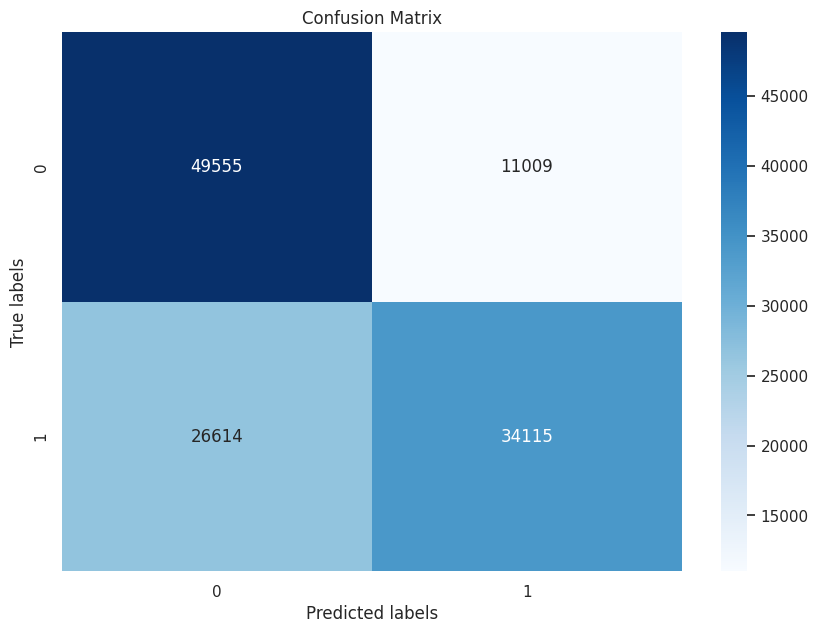

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [55]:
import numpy as np


importance_dict = loaded_bst.get_score(importance_type='weight')


sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)


comment_feature_names = tf_idf_comment.get_feature_names_out()
parent_comment_feature_names = tf_idf_parent_comment.get_feature_names_out()


combined_feature_names = np.concatenate((comment_feature_names, parent_comment_feature_names))

importance_word_pairs = [(combined_feature_names[int(idx[1:])], importance) for idx, importance in sorted_importances]





In [56]:
for word, importance in importance_word_pairs[:10]:
    print(f'Word: {word}, Importance: {importance}')

Word: the, Importance: 2223.0
Word: to, Importance: 1553.0
Word: the, Importance: 1417.0
Word: of, Importance: 1384.0
Word: it, Importance: 1336.0
Word: you, Importance: 1198.0
Word: and, Importance: 1150.0
Word: but, Importance: 1122.0
Word: that, Importance: 1114.0
Word: it, Importance: 1019.0


In [57]:
# pip install shap

In [58]:
# import shap

# # Create a SHAP explainer
# explainer = shap.TreeExplainer(loaded_bst)
# # Assuming X_test is your test dataset prepared similarly to your training data
# shap_values = explainer.shap_values(X_test)

# # For binary classification, shap_values will be a list with two arrays: [shap_values_class_0, shap_values_class_1]
# # Focus on shap_values for the positive class (usually class 1)
# shap_values_pos_class = shap_values[1]

# # Summarize the SHAP values for the positive class
# shap.summary_plot(shap_values_pos_class, X_test, feature_names=combined_feature_names)


#Determine what features we want to engineer to help predict saracsm
* Number of Capital words in comment (parent comment too)
* Number of !, #, _, ., ? etc
* Length of the comment
* Number of curse words?

PCA on word embeddings before feeding into traditional models / dimension reduction

Take comment of the vector - TSNE analysis

Every comment should be a fixed length vector

